# Turtle Trading
The idea is that the "trend is your friend," so you should buy futures breaking out to the upside of trading ranges and sell short downside breakouts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import pandas_datareader.data as web
import pickle 
import requests

C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
image_path = 'D:/kenneth/agent/images/'
ticker = '^GSPC'
start=('2019-01-01')
end=('2020-05-08')
# df=web.DataReader(ticker,'yahoo',start,end)
# df.to_csv(ticker+'.csv')
df = pd.read_csv('D:/kenneth/models/data/sp500/prices/data/'+ticker+'.csv', index_col=0, parse_dates=True)

#  Agents

* Turtle Trading agent
* Moving Average agent
* Signal Rolling agent
* Policy Gradient agent
* Q-learning agent
* Evolution Strategy agent
* Double Q-learning agent
* Recurrent Q-learning agent
* Double Recurrent Q-learning agent
* Duel Q-learning agent
* Double Duel Q-learning agent
* Duel Recurrent Q-learning agent
* Double Duel Recurrent Q-learning agent
* Actor-critic agent
* Actor-critic Duel agent
* Actor-critic Recurrent agent
* Actor-critic Duel Recurrent agent
* Curiosity Q-learning agent
* Recurrent Curiosity Q-learning agent
* Duel Curiosity Q-learning agent
* Neuro-evolution agent
* Neuro-evolution with Novelty search agent
* ABCD strategy agent
* Deep Evolution Strategy

## Turtle Trading Agent

In [3]:
name = 'Turtle Trading Agent'
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index) # make a pandas series of the Index
signals['signal'] = 0.0 # populate the series with zeros
signals['trend'] = df['Close'] # populate the trend column with closing price
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max()) # shift up by 1 period 
#and take the rolling max of 10% of the entire length(rows) of the close data in the trend column
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
#similar to previous column but take the minimum
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
# if the closing price is greater than the rolling max column assign -1 to the signal
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
# if the closing price is less than the rolling min column assign +1 to the signal
signals[signals.signal==1].head()

,signal,trend,RollingMax,RollingMin
Date,,,,
2002-07-19,1.0,847.750000,1527.459961,876.989990
2002-07-22,1.0,819.849976,1527.459961,847.750000
2002-07-23,1.0,797.700012,1527.459961,819.849976
2002-10-07,1.0,785.280029,1527.459961,797.700012
2002-10-09,1.0,776.760010,1527.459961,785.280029


In [4]:
signals[signals.signal==-1].head()

,signal,trend,RollingMax,RollingMin
Date,,,,
1979-08-15,-1.0,108.250000,107.830002,62.279999
1979-08-17,-1.0,108.300003,108.250000,62.279999
1979-08-20,-1.0,108.830002,108.300003,62.279999
1979-08-21,-1.0,108.910004,108.830002,62.279999
1979-08-22,-1.0,108.989998,108.910004,62.279999


In [5]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [6]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 2430: cannot sell anything, inventory 0
day 2432: cannot sell anything, inventory 0
day 2433: cannot sell anything, inventory 0
day 2434: cannot sell anything, inventory 0
day 2435: cannot sell anything, inventory 0
day 2438: cannot sell anything, inventory 0
day 2442: cannot sell anything, inventory 0
day 2455: cannot sell anything, inventory 0
day 2466: cannot sell anything, inventory 0
day 2539: cannot sell anything, inventory 0
day 2541: cannot sell anything, inventory 0
day 2542: cannot sell anything, inventory 0
day 2544: cannot sell anything, inventory 0
day 2546: cannot sell anything, inventory 0
day 2551: cannot sell anything, inventory 0
day 2552: cannot sell anything, inventory 0
day 2553: cannot sell anything, inventory 0
day 2556: cannot sell anything, inventory 0
day 2660: cannot sell anything, inventory 0
day 2663: cannot sell anything, inventory 0
day 2664: cannot sell anything, inventory 0
day 2665: cannot sell anything, inventory 0
day 2678: cannot sell anything, 

day 7199: cannot sell anything, inventory 0
day 7200: cannot sell anything, inventory 0
day 7202: cannot sell anything, inventory 0
day 7204: cannot sell anything, inventory 0
day 7206: cannot sell anything, inventory 0
day 7210: cannot sell anything, inventory 0
day 7212: cannot sell anything, inventory 0
day 7213: cannot sell anything, inventory 0
day 7303: cannot sell anything, inventory 0
day 7306: cannot sell anything, inventory 0
day 7322: cannot sell anything, inventory 0
day 7323: cannot sell anything, inventory 0
day 7324: cannot sell anything, inventory 0
day 7327: cannot sell anything, inventory 0
day 7331: cannot sell anything, inventory 0
day 7332: cannot sell anything, inventory 0
day 7334: cannot sell anything, inventory 0
day 7348: cannot sell anything, inventory 0
day 7373: cannot sell anything, inventory 0
day 7375: cannot sell anything, inventory 0
day 7376: cannot sell anything, inventory 0
day 7378: cannot sell anything, inventory 0
day 7381: cannot sell anything, 

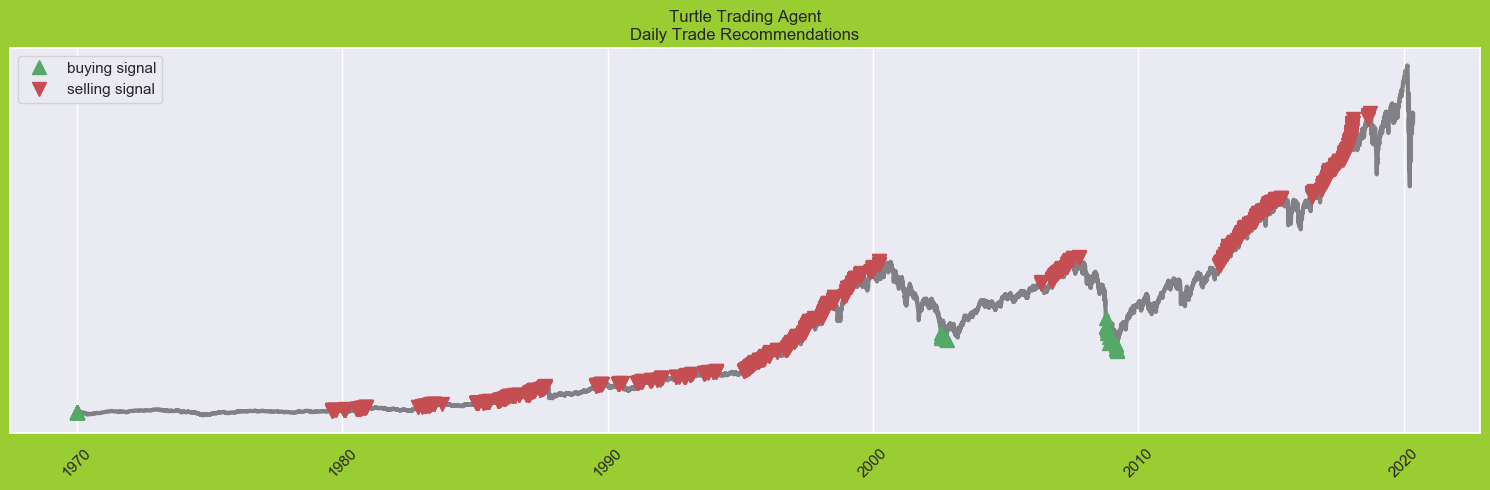

In [7]:
close = df['Close']
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=3., alpha=0.5)
plt.plot(close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title(name+'\n'+'Daily Trade Recommendations')
plt.legend()
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()


In [8]:
display_days = 30
total_days= df.shape[0]
display_from = total_days-display_days

In [9]:
new_buy = []
for i in(states_buy):
    if i > display_from:
        adj = i- display_from
        new_buy.append(adj)
new_buy

[]

In [10]:
new_sell = []
for i in(states_sell):
    if i > display_from:
        adj = i- display_from
        new_sell.append(adj)
new_sell

[]

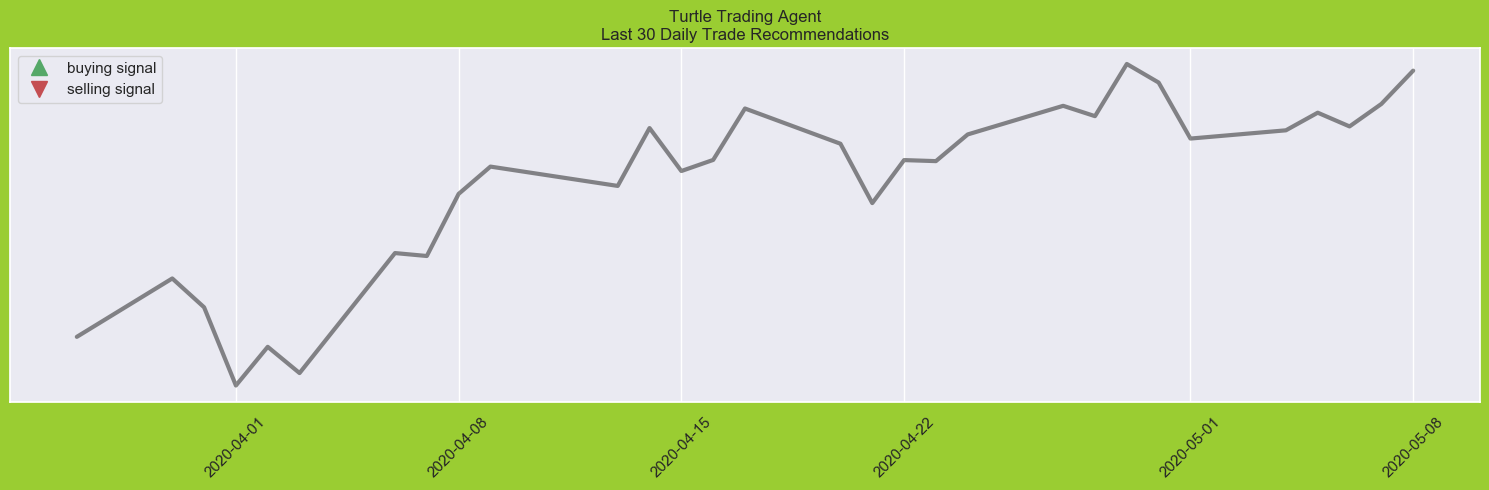

In [11]:
close = df['Close'][-display_days:]
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=3., alpha=0.5)
plt.plot(close, '^', markersize=12, color='g',alpha=1.0,label = 'buying signal', markevery = new_buy)
plt.plot(close, 'v', markersize=12, color='r',alpha=1.0, label = 'selling signal', markevery = new_sell)
plt.title(name+'\n'+'Last '+str(display_days)+' Daily Trade Recommendations')
plt.legend()
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
#plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()